In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Data

## Image path

In [2]:
train_dir = "../input/tomatoleaf/tomato/train"
test_dir = "../input/tomatoleaf/tomato/val"

## Data Rescaling and augmentation

In [3]:
#import tensorflow as tf

# Define the image size
image_size = (224, 224)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(image_size[0], image_size[0], 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name="data_augmentation")


## Load datasets (Shuffle and prefetch)

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


## Visualize data

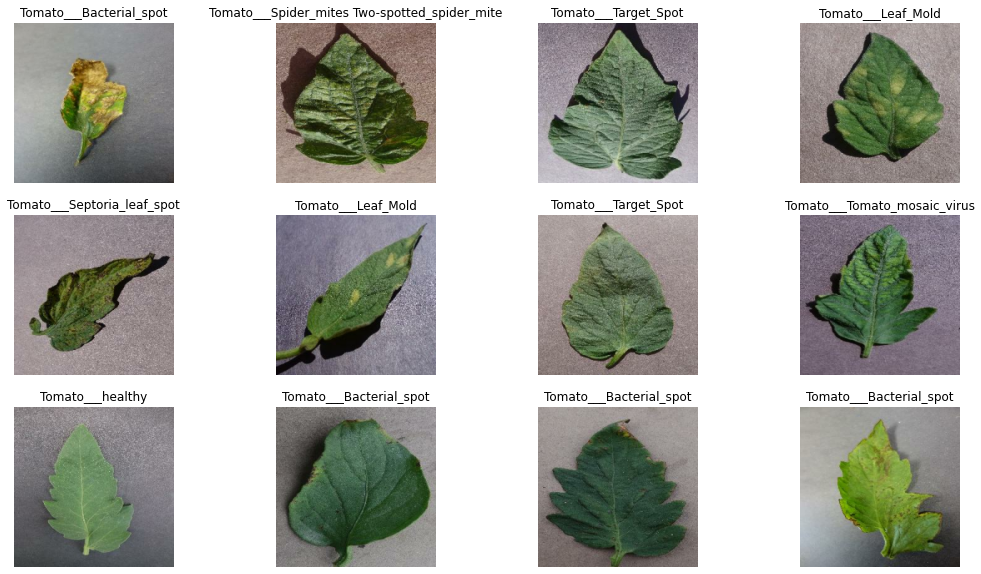

In [5]:
plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

## Augmented image view

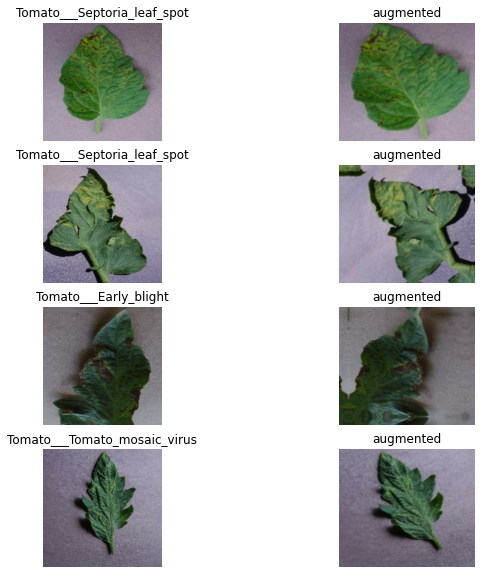

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

# Create Checkpoint

In [7]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [8]:
import tensorflow as tf

model0 = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

## Summary

In [9]:
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Compile model

In [10]:
model0.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [11]:
history = model0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/5
313/313 [==============================] - 144s 454ms/step - loss: 2.1249 - accuracy: 0.2077 - val_loss: 1.8957 - val_accuracy: 0.3180
Epoch 2/5
313/313 [==============================] - 142s 454ms/step - loss: 1.7134 - accuracy: 0.3851 - val_loss: 1.5825 - val_accuracy: 0.4100
Epoch 3/5
313/313 [==============================] - 141s 450ms/step - loss: 1.4606 - accuracy: 0.4871 - val_loss: 1.4003 - val_accuracy: 0.4900
Epoch 4/5
313/313 [==============================] - 142s 454ms/step - loss: 1.2980 - accuracy: 0.5430 - val_loss: 1.1259 - val_accuracy: 0.6360
Epoch 5/5
313/313 [==============================] - 142s 453ms/step - loss: 1.1582 - accuracy: 0.5970 - val_loss: 1.1720 - val_accuracy: 0.6150


In [45]:
import keras_tuner as kt

In [50]:
def build_model(hp):
    
    model=Sequential()
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1,activation='softmax'))
    
    optimizer=hp.Choice('optimizer',values = ['sgd','rmsprop','adadelta'])
    
    model.compile(optimizer=optimizer,loss= 'categorical_crossentropy',metrics=['accuracy'])
    
    return model

# Making a tunner object 

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [52]:
tuner=kt.RandomSearch(build_model,
                      objective='val_accuracy',
                      max_trials=5
                     )

In [61]:
tuner.search(train_data,epochs=5,validation_data=(test_data))

# #Evalute the model !

In [68]:
model0.evaluate(train_data)

313/313 [==============================] - 3s 11ms/step - loss: 0.6945 - accuracy: 0.7605


[0.694477915763855, 0.7605000138282776]

In [45]:
model0.evaluate(test_data)

32/32 [==============================] - 2s 36ms/step - loss: 0.7274 - accuracy: 0.7420


[0.7273769974708557, 0.7419999837875366]

In [46]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

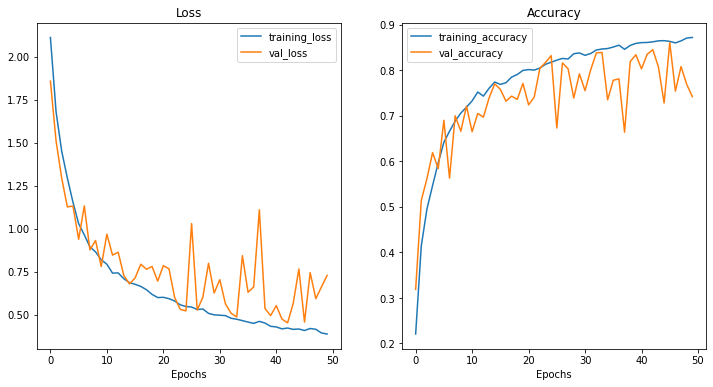

In [47]:
plot_loss_curves(history)

# #Compile second model !

In [15]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 10)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    2912      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)               

In [17]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [20]:
history = model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer conv2d_3 is incompatible with the layer: expected axis -1 of input shape to have value 10 but received input with shape (None, None, None, 3)


In [28]:
model.evaluate(test_data)

32/32 [==============================] - 2s 36ms/step - loss: 0.7083 - accuracy: 0.7770


[0.708339512348175, 0.7770000100135803]

In [29]:
model.evaluate(train_data)

313/313 [==============================] - 4s 11ms/step - loss: 0.6311 - accuracy: 0.7944


[0.6311240792274475, 0.7943999767303467]

# Create plot_loss_curve function

In [31]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

# #plot the model!

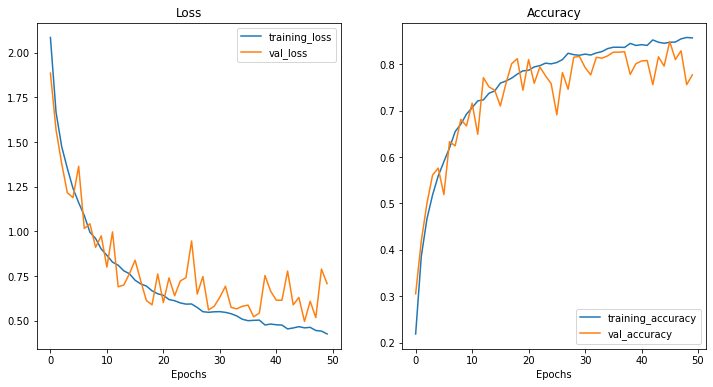

In [32]:
plot_loss_curves(history) # when we applied averagemaxpooling instead of maxpooling layers.

## Evaluate best model

### Load the best weight

In [34]:
model.load_weights(checkpoint_path)

In [48]:
model.evaluate(train_data), model.evaluate(test_data)

32/32 [==============================] - 2s 37ms/step - loss: 0.4969 - accuracy: 0.8490


([0.44208824634552, 0.8521000146865845],
 [0.49690791964530945, 0.8489999771118164])

# Load pretrain model

## Download pre train model

In [49]:
! wget "https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5"

--2023-07-05 10:01:46--  https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Tomato-leaf-disease/main/pretrain_model.h5 [following]
--2023-07-05 10:01:47--  https://raw.githubusercontent.com/HSAkash/Tomato-leaf-disease/main/pretrain_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173280 (169K) [application/octet-stream]
Saving to: ‘pretrain_model.h5’

pretrain_model.h5   100%[===================>] 169.22K  --.-KB/s    in 0.02s   

2023-07-05 10:01:47 (6.81 MB/s) - ‘pretrain_model.h5’ saved [173280/173280]



## Laod model

In [50]:
load_model = tf.keras.models.load_model("pretrain_model.h5")

## summary of load data

In [51]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Evaluate load model with valid data or test_data

In [52]:
load_model.evaluate(train_data),load_model.evaluate(test_data)

32/32 [==============================] - 2s 42ms/step - loss: 0.2603 - accuracy: 0.9420


([0.11484743654727936, 0.9645000100135803],
 [0.2602568566799164, 0.9419999718666077])

# Prediction && visualize

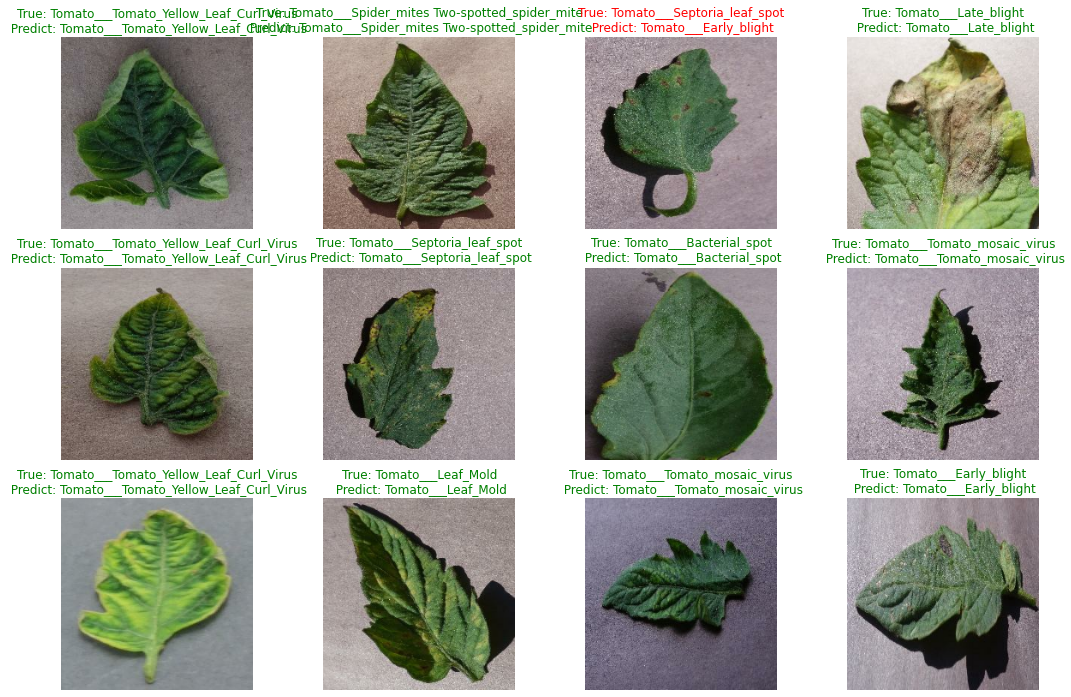

In [53]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

# Confusion matrix

In [54]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


## Predict y_pred and get y_true

In [55]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

## Plot confusion matrix

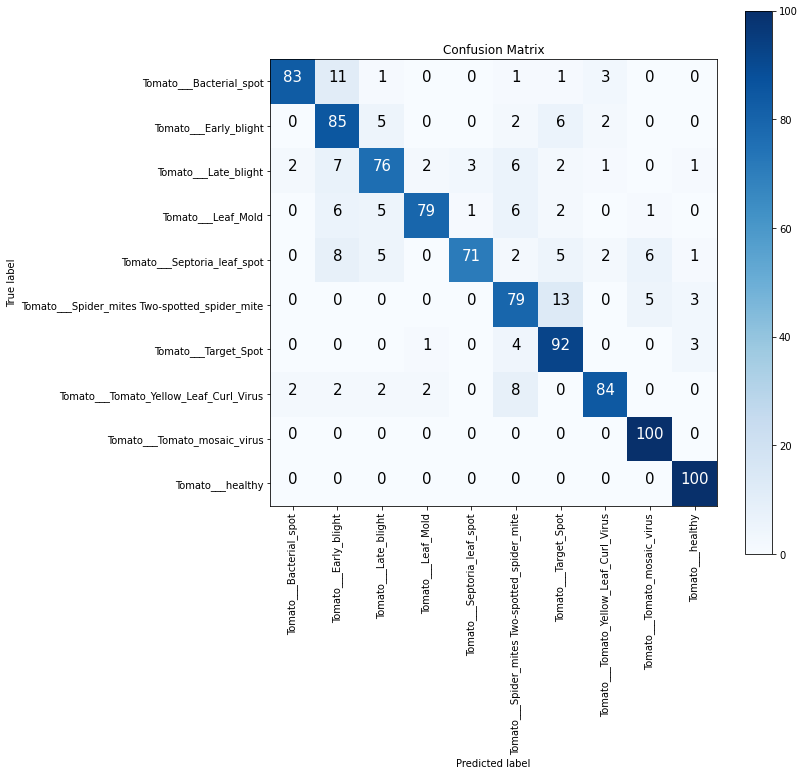

In [56]:
make_confusion_matrix(y_true, y_pred, class_names)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.95      0.83      0.89       100
                        Tomato___Early_blight       0.71      0.85      0.78       100
                         Tomato___Late_blight       0.81      0.76      0.78       100
                           Tomato___Leaf_Mold       0.94      0.79      0.86       100
                  Tomato___Septoria_leaf_spot       0.95      0.71      0.81       100
Tomato___Spider_mites Two-spotted_spider_mite       0.73      0.79      0.76       100
                         Tomato___Target_Spot       0.76      0.92      0.83       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.91      0.84      0.87       100
                 Tomato___Tomato_mosaic_virus       0.89      1.00      0.94       100
                             Tomato___healthy       0.93      1.00      0.96       100

                                     accu

# #Done ! 

# Combining the two model VGG-16 & VGG-19 

In [10]:
import tensorflow as tf

# Load the pre-trained VGG16 model without the top classification layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained VGG19 model without the top classification layers
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg16.trainable = False
vgg19.trainable = False

# Create your own classification layers for VGG16
model_vgg16 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for VGG19
model_vgg19 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of both models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
vgg16_pred = model_vgg16(ensemble_input)
vgg19_pred = model_vgg19(ensemble_input)
ensemble_output = tf.keras.layers.Average()([vgg16_pred, vgg19_pred])

# Create the final ensemble model
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


80150528/80134624 [==============================] - 0s 0us/step


In [11]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           21140042    input_5[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 10)           26449738    input_5[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 10)           0           sequential_1[0][0]               
                                                                 sequential_2[0][0]           

In [12]:
ensemble_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [25]:
history = ensemble_model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/50
313/313 [==============================] - 127s 342ms/step - loss: 10.3438 - accuracy: 0.1696 - val_loss: 10.2124 - val_accuracy: 0.1280
Epoch 2/50
313/313 [==============================] - 99s 318ms/step - loss: 9.6872 - accuracy: 0.1967 - val_loss: 8.1330 - val_accuracy: 0.2830
Epoch 3/50
313/313 [==============================] - 100s 319ms/step - loss: 8.3553 - accuracy: 0.2414 - val_loss: 8.2762 - val_accuracy: 0.2130
Epoch 4/50
313/313 [==============================] - 100s 319ms/step - loss: 7.8083 - accuracy: 0.2489 - val_loss: 6.8968 - val_accuracy: 0.3290
Epoch 5/50
313/313 [==============================] - 100s 319ms/step - loss: 7.7783 - accuracy: 0.2570 - val_loss: 7.7684 - val_accuracy: 0.2920
Epoch 6/50
313/313 [==============================] - 99s 317ms/step - loss: 6.7220 - accuracy: 0.2902 - val_loss: 5.5874 - val_accuracy: 0.3580
Epoch 7/50
313/313 [==============================] - 100s 319ms/step - loss: 6.5595 - accuracy: 0.2764 - val_loss: 4.7457 -

In [26]:
ensemble_model.evaluate(train_data)

313/313 [==============================] - 90s 287ms/step - loss: 3.4038 - accuracy: 0.3301


[3.4037797451019287, 0.33009999990463257]

In [27]:
ensemble_model.evaluate(test_data)

32/32 [==============================] - 9s 278ms/step - loss: 3.9293 - accuracy: 0.3290


[3.9292726516723633, 0.32899999618530273]

# Combining the ResNet50 and Xception Model !

In [27]:
import tensorflow as tf

# Load the pre-trained ResNet50 model without the top classification layers
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained Xception model without the top classification layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
resnet50.trainable = False
xception.trainable = False

# Create your own classification layers for ResNet50
model_resnet50 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for Xception
model_xception = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of both models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
resnet50_pred = model_resnet50(ensemble_input)
xception_pred = model_xception(ensemble_input)
ensemble_output = tf.keras.layers.Average()([resnet50_pred, xception_pred])

# Create the final ensemble model
ensemble_model1 = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


In [28]:
ensemble_model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 10)           49280650    input_15[0][0]                   
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 10)           21388594    input_15[0][0]                   
__________________________________________________________________________________________________
average_2 (Average)             (None, 10)           0           sequential_5[0][0]               
                                                                 sequential_6[0][0]         

In [29]:
ensemble_model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [36]:
# Model fitting
history = ensemble_model1.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 88s 257ms/step - loss: 5.7279 - accuracy: 0.1875 - val_loss: 1.8821 - val_accuracy: 0.2450
Epoch 2/50
313/313 [==============================] - 76s 244ms/step - loss: 1.8821 - accuracy: 0.2546 - val_loss: 1.6097 - val_accuracy: 0.3130
Epoch 3/50
313/313 [==============================] - 76s 244ms/step - loss: 1.6837 - accuracy: 0.3066 - val_loss: 1.6972 - val_accuracy: 0.2770
Epoch 4/50
313/313 [==============================] - 76s 243ms/step - loss: 1.7016 - accuracy: 0.3010 - val_loss: 1.5664 - val_accuracy: 0.2670
Epoch 5/50
313/313 [==============================] - 76s 244ms/step - loss: 1.6114 - accuracy: 0.3036 - val_loss: 1.3914 - val_accuracy: 0.3240
Epoch 6/50
313/313 [==============================] - 76s 244ms/step - loss: 1.5565 - accuracy: 0.3106 - val_loss: 1.4618 - val_accuracy: 0.3030
Epoch 7/50
313/313 [==============================] - 76s 243ms/step - loss: 1.5293 - accuracy: 0.3168 - val_loss: 1.3533 - val_ac

In [37]:
ensemble_model1.evaluate(train_data)

313/313 [==============================] - 68s 217ms/step - loss: 0.8161 - accuracy: 0.4963


[0.8161473274230957, 0.49630001187324524]

In [38]:
ensemble_model1.evaluate(test_data)

32/32 [==============================] - 8s 220ms/step - loss: 1.0563 - accuracy: 0.4760


[1.0563336610794067, 0.47600001096725464]

# Combining the MobileNet and EfficientNetB0 Model !

In [43]:
import tensorflow as tf

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
mobilenet.trainable = False
efficientnet.trainable = False

# Create your own classification layers for MobileNet
model_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for EfficientNetB0
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of both models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
mobilenet_pred = model_mobilenet(ensemble_input)
efficientnet_pred = model_efficientnet(ensemble_input)
ensemble_output = tf.keras.layers.Average()([mobilenet_pred, efficientnet_pred])

# Create the final ensemble model
ensemble_model2 = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


16719872/16705208 [==============================] - 0s 0us/step


In [44]:
ensemble_model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 10)           16076746    input_20[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 10)           20108717    input_20[0][0]                   
__________________________________________________________________________________________________
average_3 (Average)             (None, 10)           0           sequential_7[0][0]               
                                                                 sequential_8[0][0]         

In [45]:
ensemble_model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [46]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [47]:
# Model fitting
history = ensemble_model2.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 44s 118ms/step - loss: 3.9232 - accuracy: 0.1137 - val_loss: 1.4903 - val_accuracy: 0.1000
Epoch 2/50
313/313 [==============================] - 33s 106ms/step - loss: 1.5094 - accuracy: 0.1030 - val_loss: 1.2399 - val_accuracy: 0.1020
Epoch 3/50
313/313 [==============================] - 33s 107ms/step - loss: 1.2798 - accuracy: 0.1085 - val_loss: 1.2082 - val_accuracy: 0.1230
Epoch 4/50
313/313 [==============================] - 33s 106ms/step - loss: 1.2850 - accuracy: 0.1142 - val_loss: 1.1760 - val_accuracy: 0.1070
Epoch 5/50
313/313 [==============================] - 33s 106ms/step - loss: 1.1649 - accuracy: 0.1100 - val_loss: 1.1256 - val_accuracy: 0.1210
Epoch 6/50
313/313 [==============================] - 33s 106ms/step - loss: 1.1103 - accuracy: 0.1205 - val_loss: 1.2263 - val_accuracy: 0.1140
Epoch 7/50
313/313 [==============================] - 33s 107ms/step - loss: 1.0730 - accuracy: 0.1269 - val_loss: 1.1287 - val_ac

In [48]:
ensemble_model2.evaluate(train_data)

313/313 [==============================] - 29s 92ms/step - loss: 0.7065 - accuracy: 0.1273


[0.7065459489822388, 0.12729999423027039]

In [49]:
ensemble_model2.evaluate(test_data)

32/32 [==============================] - 4s 97ms/step - loss: 1.1854 - accuracy: 0.1220


[1.1853687763214111, 0.12200000137090683]

# #Combining three model , Xception,MobileNet & EfficientNetB0 !

In [51]:
import tensorflow as tf

# Load the pre-trained Xception model without the top classification layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
xception.trainable = False
mobilenet.trainable = False
efficientnet.trainable = False

# Create your own classification layers for Xception
model_xception = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for MobileNet
model_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for EfficientNetB0
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of all three models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
xception_pred = model_xception(ensemble_input)
mobilenet_pred = model_mobilenet(ensemble_input)
efficientnet_pred = model_efficientnet(ensemble_input)
ensemble_output = tf.keras.layers.Average()([xception_pred, mobilenet_pred, efficientnet_pred])

# Create the final ensemble model
ensemble_model3 = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


In [52]:
ensemble_model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 10)           21388594    input_33[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 10)           16076746    input_33[0][0]                   
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 10)           20108717    input_33[0][0]                   
____________________________________________________________________________________________

In [53]:
ensemble_model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [54]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [55]:
# Model fitting
history = ensemble_model3.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 87s 250ms/step - loss: 4.6218 - accuracy: 0.1953 - val_loss: 1.9779 - val_accuracy: 0.3310
Epoch 2/50
313/313 [==============================] - 75s 240ms/step - loss: 1.7103 - accuracy: 0.4167 - val_loss: 1.4936 - val_accuracy: 0.4480
Epoch 3/50
313/313 [==============================] - 75s 240ms/step - loss: 1.4942 - accuracy: 0.4901 - val_loss: 1.3586 - val_accuracy: 0.4910
Epoch 4/50
313/313 [==============================] - 75s 239ms/step - loss: 1.4697 - accuracy: 0.5153 - val_loss: 1.3273 - val_accuracy: 0.5590
Epoch 5/50
313/313 [==============================] - 75s 239ms/step - loss: 1.3764 - accuracy: 0.5558 - val_loss: 1.2748 - val_accuracy: 0.5510
Epoch 6/50
313/313 [==============================] - 75s 239ms/step - loss: 1.3452 - accuracy: 0.5620 - val_loss: 1.3106 - val_accuracy: 0.5530
Epoch 7/50
313/313 [==============================] - 75s 239ms/step - loss: 1.3720 - accuracy: 0.5485 - val_loss: 1.2219 - val_ac

In [56]:
ensemble_model3.evaluate(train_data)

313/313 [==============================] - 67s 213ms/step - loss: 0.8902 - accuracy: 0.7680


[0.8901624083518982, 0.7680000066757202]

In [57]:
ensemble_model3.evaluate(test_data)

32/32 [==============================] - 7s 209ms/step - loss: 1.0897 - accuracy: 0.7020


[1.0896979570388794, 0.7020000219345093]

# Combining the three model,ResNet50,MobileNet and EfficientNetB0 !

In [62]:
import tensorflow as tf

# Load the pre-trained ResNet50 model without the top classification layers
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
resnet50.trainable = False
mobilenet.trainable = False
efficientnet.trainable = False

# Create your own classification layers for ResNet50
model_resnet50 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for MobileNet
model_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Create your own classification layers for EfficientNetB0
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of all three models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
resnet50_pred = model_resnet50(ensemble_input)
mobilenet_pred = model_mobilenet(ensemble_input)
efficientnet_pred = model_efficientnet(ensemble_input)
ensemble_output = tf.keras.layers.Average()([resnet50_pred, mobilenet_pred, efficientnet_pred])

# Create the final ensemble model
ensemble_model4 = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


In [63]:
ensemble_model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 10)           49280650    input_60[0][0]                   
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 10)           16076746    input_60[0][0]                   
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 10)           20108717    input_60[0][0]                   
____________________________________________________________________________________________

In [64]:
ensemble_model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [65]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [66]:
# Model fitting
history = ensemble_model4.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 79s 221ms/step - loss: 7.6914 - accuracy: 0.2363 - val_loss: 4.6094 - val_accuracy: 0.3330
Epoch 2/50
313/313 [==============================] - 66s 211ms/step - loss: 3.9610 - accuracy: 0.3434 - val_loss: 1.7128 - val_accuracy: 0.3370
Epoch 3/50
313/313 [==============================] - 66s 211ms/step - loss: 1.6850 - accuracy: 0.2971 - val_loss: 1.4429 - val_accuracy: 0.3390
Epoch 4/50
313/313 [==============================] - 67s 213ms/step - loss: 1.5418 - accuracy: 0.3103 - val_loss: 1.4356 - val_accuracy: 0.3150
Epoch 5/50
313/313 [==============================] - 66s 211ms/step - loss: 1.4861 - accuracy: 0.3241 - val_loss: 1.3390 - val_accuracy: 0.3750
Epoch 6/50
313/313 [==============================] - 66s 210ms/step - loss: 1.4046 - accuracy: 0.3331 - val_loss: 1.3286 - val_accuracy: 0.3600
Epoch 7/50
313/313 [==============================] - 66s 211ms/step - loss: 1.3588 - accuracy: 0.3150 - val_loss: 1.3705 - val_ac

In [68]:
ensemble_model4.evaluate(train_data)

313/313 [==============================] - 58s 184ms/step - loss: 0.6971 - accuracy: 0.6272


[0.697086751461029, 0.6272000074386597]

In [69]:
ensemble_model4.evaluate(test_data)

32/32 [==============================] - 7s 190ms/step - loss: 1.0819 - accuracy: 0.5860


[1.081891655921936, 0.5860000252723694]

# #Combining the four model ,MobileNet,Xception,ResNet50 and EfficientNetB0 !

In [11]:
import tensorflow as tf

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
mobilenet.trainable = False

# Create your own classification layers for MobileNet
model_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Load the pre-trained Xception model without the top classification layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
xception.trainable = False

# Create your own classification layers for Xception
model_xception = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Load the pre-trained ResNet50 model without the top classification layers
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
resnet50.trainable = False

# Create your own classification layers for ResNet50
model_resnet50 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
efficientnet.trainable = False

# Create your own classification layers for EfficientNetB0
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Combine the predictions of all four models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
mobilenet_pred = model_mobilenet(ensemble_input)
xception_pred = model_xception(ensemble_input)
resnet50_pred = model_resnet50(ensemble_input)
efficientnet_pred = model_efficientnet(ensemble_input)
ensemble_output = tf.keras.layers.Average()([mobilenet_pred, xception_pred, resnet50_pred, efficientnet_pred])

# Create the final ensemble model
ensemble_model5 = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


16719872/16705208 [==============================] - 0s 0us/step


In [12]:
ensemble_model5.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           16076746    input_11[0][0]                   
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 10)           21388594    input_11[0][0]                   
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 10)           49280650    input_11[0][0]                   
______________________________________________________________________________________________

In [13]:
ensemble_model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [16]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [17]:
# Model fitting
history = ensemble_model5.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 146s 381ms/step - loss: 6.6955 - accuracy: 0.1748 - val_loss: 5.8617 - val_accuracy: 0.1850
Epoch 2/50
313/313 [==============================] - 112s 357ms/step - loss: 2.8821 - accuracy: 0.2230 - val_loss: 1.9194 - val_accuracy: 0.2210
Epoch 3/50
313/313 [==============================] - 111s 356ms/step - loss: 2.0598 - accuracy: 0.2791 - val_loss: 1.8105 - val_accuracy: 0.3220
Epoch 4/50
313/313 [==============================] - 112s 358ms/step - loss: 1.9657 - accuracy: 0.2984 - val_loss: 1.7993 - val_accuracy: 0.3020
Epoch 5/50
313/313 [==============================] - 112s 357ms/step - loss: 1.9814 - accuracy: 0.2711 - val_loss: 1.7817 - val_accuracy: 0.2950
Epoch 6/50
313/313 [==============================] - 112s 357ms/step - loss: 2.0190 - accuracy: 0.2384 - val_loss: 1.7764 - val_accuracy: 0.2920
Epoch 7/50
313/313 [==============================] - 112s 357ms/step - loss: 1.9192 - accuracy: 0.2947 - val_loss: 1.7267 -

# #Implimentation of VGG19 Model !

In [59]:
import tensorflow as tf

# Load the pre-trained VGG19 model without the top classification layers
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg19.trainable = False

# Create your own classification layers
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

80150528/80134624 [==============================] - 0s 0us/step


In [60]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 26,449,738
Trainable params: 6,425,354
Non-trainable params: 20,024,384
_________________________________________________________________


In [61]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !


In [64]:
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
 checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [66]:

# Model fitting
history = model2.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 66s 189ms/step - loss: 2.7870 - accuracy: 0.4156 - val_loss: 1.3024 - val_accuracy: 0.6140
Epoch 2/50
313/313 [==============================] - 54s 172ms/step - loss: 1.5344 - accuracy: 0.4874 - val_loss: 1.2435 - val_accuracy: 0.6480
Epoch 3/50
313/313 [==============================] - 53s 169ms/step - loss: 1.3102 - accuracy: 0.5696 - val_loss: 1.0632 - val_accuracy: 0.7000
Epoch 4/50
313/313 [==============================] - 54s 171ms/step - loss: 1.1726 - accuracy: 0.6037 - val_loss: 0.9699 - val_accuracy: 0.7520
Epoch 5/50
313/313 [==============================] - 54s 171ms/step - loss: 1.0887 - accuracy: 0.6168 - val_loss: 1.0167 - val_accuracy: 0.7540
Epoch 6/50
313/313 [==============================] - 53s 171ms/step - loss: 1.0380 - accuracy: 0.6493 - val_loss: 0.8636 - val_accuracy: 0.7650
Epoch 7/50
313/313 [==============================] - 53s 169ms/step - loss: 0.9519 - accuracy: 0.6622 - val_loss: 0.8497 - val_ac

# #Model Evaluation ! 

In [69]:
model2.evaluate(train_data)

313/313 [==============================] - 48s 152ms/step - loss: 0.0848 - accuracy: 0.9774


[0.08484731614589691, 0.977400004863739]

In [70]:
model2.evaluate(test_data)

32/32 [==============================] - 5s 149ms/step - loss: 0.8223 - accuracy: 0.8520


[0.8223138451576233, 0.8519999980926514]

In [36]:
#model2.evaluate(train_data)

313/313 [==============================] - 24s 76ms/step - loss: 0.0914 - accuracy: 0.9683


[0.09144852310419083, 0.9682999849319458]

In [39]:
#model2.evaluate(test_data)

32/32 [==============================] - 3s 82ms/step - loss: 0.8685 - accuracy: 0.8430


[0.8685036301612854, 0.8429999947547913]

# #Plotting the Confusion matrix of the given data !

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [41]:
import numpy as np

y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)


In [43]:
cm=confusion_matrix(y_true, y_pred)

In [44]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                         ):
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix ! ")
        
    else:
        print('Confustion matrix , without normalization !')
        
    print(cm)
    
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
         
    plt.tight_layout()
    plt.ylabel('True label')

Confustion matrix , without normalization !
[[78  5  2  0  0  1  4  7  0  3]
 [ 5 71 14  0  0  2  3  2  0  3]
 [ 5 16 43  2  1 13  0  5  2 13]
 [ 0 17 19 33  9  8  0  3  9  2]
 [ 2  7 10  2 34 13  7  2 15  8]
 [ 0 12  3  0  0 50 27  1  5  2]
 [ 0 13  0  0  0  4 73  0  3  7]
 [ 2  8  0  1  2 15  0 71  1  0]
 [ 0  0  0  4  0  0  0  0 96  0]
 [ 7  3  0  3  1  0  7  0  0 79]]


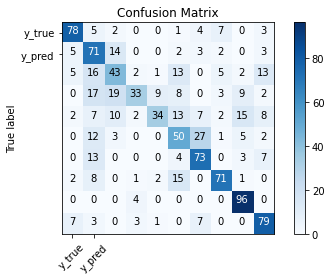

In [45]:
cm_plot_labels=['y_true','y_pred']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [46]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model2.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

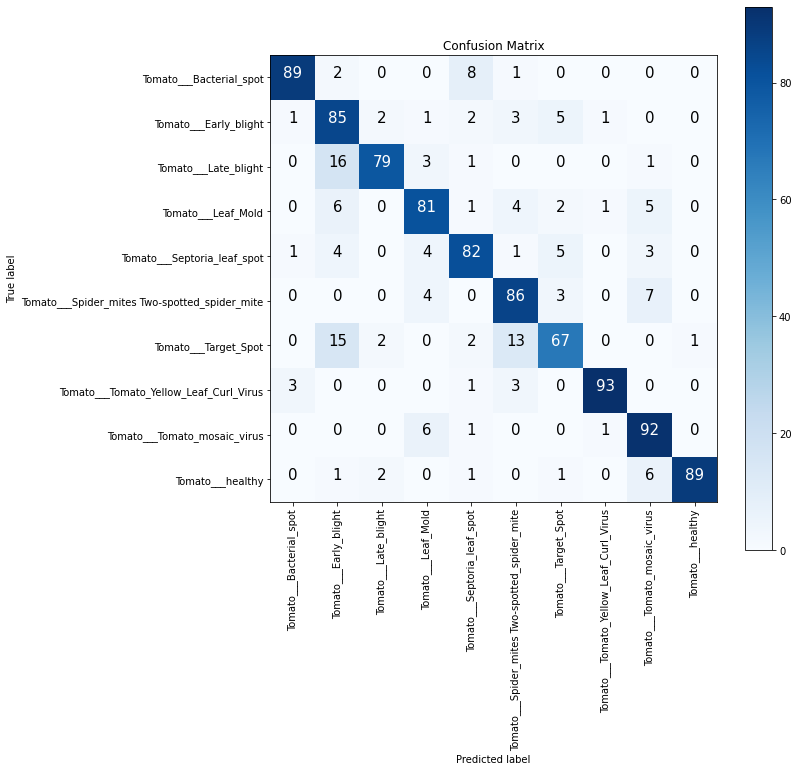

In [47]:
make_confusion_matrix(y_true, y_pred, class_names)

# #Accuracy,Precesion,Recall & F1 Score of above data !

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

# #DONE !


# #Implimentation of VGG16 Model !

In [31]:
import tensorflow as tf

# Load the pre-trained VGG16 model without the top classification layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg16.trainable = False

# Create your own classification layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


58900480/58889256 [==============================] - 0s 0us/step


In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [36]:
# Model fitting
history = model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 61s 172ms/step - loss: 3.3367 - accuracy: 0.4415 - val_loss: 1.2906 - val_accuracy: 0.5700
Epoch 2/50
313/313 [==============================] - 47s 151ms/step - loss: 1.3329 - accuracy: 0.5609 - val_loss: 0.9657 - val_accuracy: 0.7010
Epoch 3/50
313/313 [==============================] - 49s 155ms/step - loss: 1.1361 - accuracy: 0.6042 - val_loss: 0.8635 - val_accuracy: 0.7420
Epoch 4/50
313/313 [==============================] - 48s 154ms/step - loss: 1.0687 - accuracy: 0.6313 - val_loss: 0.8906 - val_accuracy: 0.7520
Epoch 5/50
313/313 [==============================] - 48s 154ms/step - loss: 1.0002 - accuracy: 0.6543 - val_loss: 0.8295 - val_accuracy: 0.7940
Epoch 6/50
313/313 [==============================] - 48s 154ms/step - loss: 0.8604 - accuracy: 0.6968 - val_loss: 0.8516 - val_accuracy: 0.8100
Epoch 7/50
313/313 [==============================] - 47s 149ms/step - loss: 0.8303 - accuracy: 0.7229 - val_loss: 0.7278 - val_ac

# #Model Evaluation !

In [37]:
model.evaluate(train_data)

313/313 [==============================] - 44s 139ms/step - loss: 0.1048 - accuracy: 0.9698


[0.10476711392402649, 0.9697999954223633]

In [39]:
model.evaluate(test_data)

32/32 [==============================] - 5s 133ms/step - loss: 0.8214 - accuracy: 0.8510


[0.8213710188865662, 0.8510000109672546]

# #Drawing the confusion matrix !

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [41]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

In [42]:
from sklearn.metrics import confusion_matrix

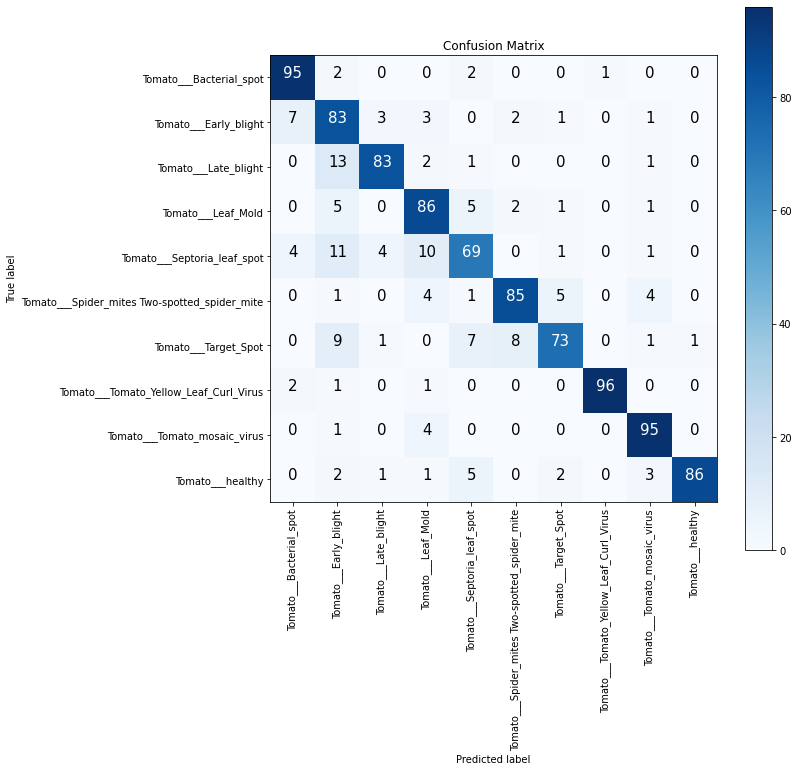

In [56]:
make_confusion_matrix(y_true, y_pred, class_names)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.88      0.95      0.91       100
                        Tomato___Early_blight       0.65      0.83      0.73       100
                         Tomato___Late_blight       0.90      0.83      0.86       100
                           Tomato___Leaf_Mold       0.77      0.86      0.82       100
                  Tomato___Septoria_leaf_spot       0.77      0.69      0.73       100
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.85      0.86       100
                         Tomato___Target_Spot       0.88      0.73      0.80       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.96      0.97       100
                 Tomato___Tomato_mosaic_virus       0.89      0.95      0.92       100
                             Tomato___healthy       0.99      0.86      0.92       100

                                     accu

# #Implimentation of ResNet50 Model !

In [66]:
import tensorflow as tf

# Load the pre-trained ResNet50 model without the top classification layers
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
resnet50.trainable = False

# Create your own classification layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


94781440/94765736 [==============================] - 1s 0us/step


In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 49,280,650
Trainable params: 25,692,938
Non-trainable params: 23,587,712
_________________________________________________________________


In [68]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early Stopping !

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

In [70]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [71]:
# Model fitting
history = model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback],
   
)

Epoch 1/50
313/313 [==============================] - 38s 111ms/step - loss: 2.4924 - accuracy: 0.4854 - val_loss: 1.0082 - val_accuracy: 0.7130
Epoch 2/50
313/313 [==============================] - 33s 106ms/step - loss: 1.3399 - accuracy: 0.5708 - val_loss: 0.8981 - val_accuracy: 0.7670
Epoch 3/50
313/313 [==============================] - 33s 107ms/step - loss: 1.1698 - accuracy: 0.6108 - val_loss: 0.8796 - val_accuracy: 0.7660
Epoch 4/50
313/313 [==============================] - 34s 107ms/step - loss: 1.0931 - accuracy: 0.6413 - val_loss: 0.7519 - val_accuracy: 0.7910
Epoch 5/50
313/313 [==============================] - 33s 107ms/step - loss: 0.9470 - accuracy: 0.6786 - val_loss: 0.5920 - val_accuracy: 0.8330
Epoch 6/50
313/313 [==============================] - 33s 107ms/step - loss: 0.8439 - accuracy: 0.7101 - val_loss: 0.5503 - val_accuracy: 0.8680
Epoch 7/50
313/313 [==============================] - 34s 107ms/step - loss: 0.7866 - accuracy: 0.7235 - val_loss: 0.6493 - val_ac

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 49,280,650
Trainable params: 25,692,938
Non-trainable params: 23,587,712
_________________________________________________________________


# #Model Evaluation ! ,Part

In [72]:
model.evaluate(train_data)

313/313 [==============================] - 29s 92ms/step - loss: 0.0807 - accuracy: 0.9839


[0.08069159090518951, 0.9839000105857849]

In [73]:
model.evaluate(test_data)

32/32 [==============================] - 4s 107ms/step - loss: 0.4782 - accuracy: 0.8950


[0.47817063331604004, 0.8949999809265137]

# #Drawing the confusion matrix !

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [76]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

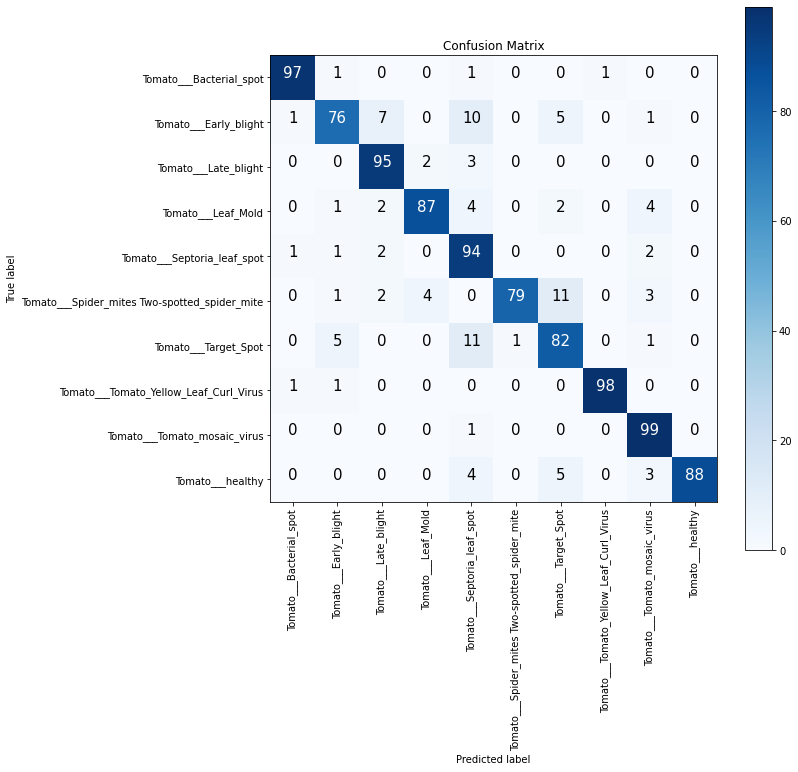

In [77]:
make_confusion_matrix(y_true, y_pred, class_names)

# #Calculation of Accuracy,Precision,Recall Value and F1 Score !

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.97      0.97       100
                        Tomato___Early_blight       0.88      0.76      0.82       100
                         Tomato___Late_blight       0.88      0.95      0.91       100
                           Tomato___Leaf_Mold       0.94      0.87      0.90       100
                  Tomato___Septoria_leaf_spot       0.73      0.94      0.82       100
Tomato___Spider_mites Two-spotted_spider_mite       0.99      0.79      0.88       100
                         Tomato___Target_Spot       0.78      0.82      0.80       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.98      0.98       100
                 Tomato___Tomato_mosaic_virus       0.88      0.99      0.93       100
                             Tomato___healthy       1.00      0.88      0.94       100

                                     accu

# #ResNet52 MODEL Done !

# #Implimentation of Inceptionv3 Model !

In [80]:
import tensorflow as tf

# Load the pre-trained InceptionV3 model without the top classification layers
inceptionv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
inceptionv3.trainable = False

# Create your own classification layers
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    inceptionv3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


87924736/87910968 [==============================] - 0s 0us/step


In [81]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 34,912,810
Trainable params: 13,110,026
Non-trainable params: 21,802,784
_________________________________________________________________


In [82]:
# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Early stopping !

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [85]:
# Model fitting
history = model3.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)


Epoch 1/50
313/313 [==============================] - 34s 92ms/step - loss: 20.9942 - accuracy: 0.1041 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 2/50
199/313 [==================>...........] - ETA: 8s - loss: 2.3041 - accuracy: 0.1017

KeyboardInterrupt: 

In [93]:
model.evaluate(train_data)

313/313 [==============================] - 18s 49ms/step - loss: 38.6338 - accuracy: 0.0962


[38.63383483886719, 0.09619999676942825]

In [94]:
model.evaluate(test_data)

32/32 [==============================] - 2s 65ms/step - loss: 39.7239 - accuracy: 0.0910


[39.723873138427734, 0.09099999815225601]

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [96]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

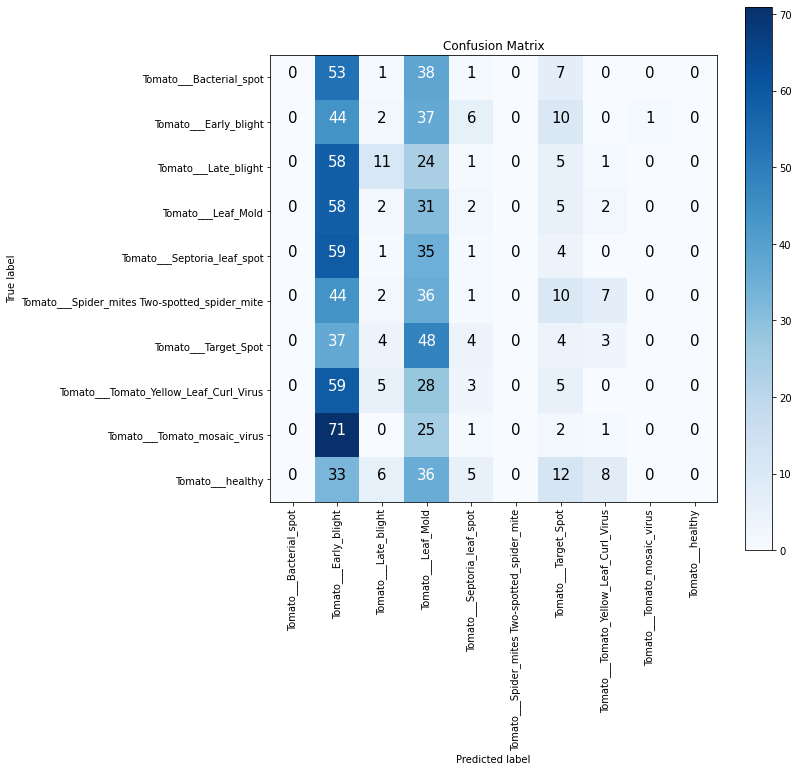

In [97]:
make_confusion_matrix(y_true, y_pred, class_names)

# #Done !

# #Implimentation of MobileNet Model!

In [46]:
import tensorflow as tf

# Load the pre-trained MobileNet model without the top classification layers
mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
mobilenet.trainable = False

# Create your own classification layers
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


17235968/17225924 [==============================] - 0s 0us/step


In [47]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 16,076,746
Trainable params: 12,847,882
Non-trainable params: 3,228,864
_________________________________________________________________


In [48]:
# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Model fitting
history = model4.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)


Epoch 1/50
313/313 [==============================] - 16s 45ms/step - loss: 2.6521 - accuracy: 0.3116 - val_loss: 1.4869 - val_accuracy: 0.5370
Epoch 2/50
313/313 [==============================] - 13s 43ms/step - loss: 1.6540 - accuracy: 0.3925 - val_loss: 1.2037 - val_accuracy: 0.6150
Epoch 3/50
313/313 [==============================] - 13s 42ms/step - loss: 1.4871 - accuracy: 0.4396 - val_loss: 1.0249 - val_accuracy: 0.6620
Epoch 4/50
313/313 [==============================] - 14s 44ms/step - loss: 1.3524 - accuracy: 0.4804 - val_loss: 1.0174 - val_accuracy: 0.6880
Epoch 5/50
313/313 [==============================] - 13s 42ms/step - loss: 1.2443 - accuracy: 0.5067 - val_loss: 0.8097 - val_accuracy: 0.7640
Epoch 6/50
313/313 [==============================] - 13s 42ms/step - loss: 1.1438 - accuracy: 0.5414 - val_loss: 0.8494 - val_accuracy: 0.7150
Epoch 7/50
313/313 [==============================] - 13s 42ms/step - loss: 1.1271 - accuracy: 0.5595 - val_loss: 0.8740 - val_accuracy:

In [50]:
model4.evaluate(train_data)

313/313 [==============================] - 11s 35ms/step - loss: 0.0986 - accuracy: 0.9772


[0.09863117337226868, 0.9771999716758728]

In [51]:
model4.evaluate(test_data)

32/32 [==============================] - 2s 52ms/step - loss: 0.7165 - accuracy: 0.7990


[0.7165103554725647, 0.7990000247955322]

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [58]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model4.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

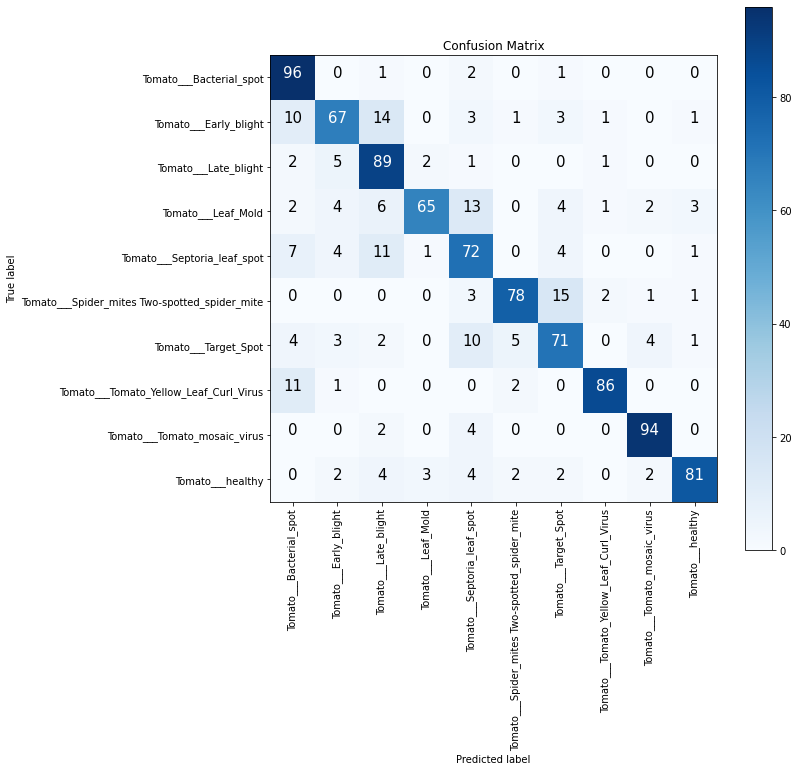

In [59]:
make_confusion_matrix(y_true, y_pred,class_names)

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.88      0.95      0.91       100
                        Tomato___Early_blight       0.65      0.83      0.73       100
                         Tomato___Late_blight       0.90      0.83      0.86       100
                           Tomato___Leaf_Mold       0.77      0.86      0.82       100
                  Tomato___Septoria_leaf_spot       0.77      0.69      0.73       100
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.85      0.86       100
                         Tomato___Target_Spot       0.88      0.73      0.80       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.96      0.97       100
                 Tomato___Tomato_mosaic_virus       0.89      0.95      0.92       100
                             Tomato___healthy       0.99      0.86      0.92       100

                                     accu

# #Done !

# #Implimentation of EfficientNetB0 Model!

In [156]:
import tensorflow as tf

# Load the pre-trained EfficientNetB0 model without the top classification layers
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
efficientnet.trainable = False

# Create your own classification layers
model5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    efficientnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


In [157]:
model5.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_10 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16056576  
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                2570      
Total params: 20,108,717
Trainable params: 16,059,146
Non-trainable params: 4,049,571
_________________________________________________________________


In [158]:

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [160]:
from tensorflow.keras.callbacks import EarlyStopping

In [161]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [163]:
# Model fitting
history = model5.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3454 - accuracy: 0.8752 - val_loss: 0.5372 - val_accuracy: 0.8870
Epoch 2/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3383 - accuracy: 0.8799 - val_loss: 0.4704 - val_accuracy: 0.9080
Epoch 3/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3300 - accuracy: 0.8807 - val_loss: 0.5296 - val_accuracy: 0.8970
Epoch 4/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3153 - accuracy: 0.8865 - val_loss: 0.6085 - val_accuracy: 0.8860
Epoch 5/20
313/313 [==============================] - 15s 48ms/step - loss: 0.3070 - accuracy: 0.8894 - val_loss: 0.4401 - val_accuracy: 0.8960
Epoch 6/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3049 - accuracy: 0.8922 - val_loss: 0.4630 - val_accuracy: 0.8940
Epoch 7/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3081 - accuracy: 0.8902 - val_loss: 0.6023 - val_accuracy:

In [165]:
model5.evaluate(train_data)

313/313 [==============================] - 13s 41ms/step - loss: 0.0099 - accuracy: 0.9968


[0.009887855499982834, 0.9968000054359436]

In [166]:
model5.evaluate(test_data)

32/32 [==============================] - 2s 52ms/step - loss: 0.7075 - accuracy: 0.8990


[0.7075234651565552, 0.8989999890327454]

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [180]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model5.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

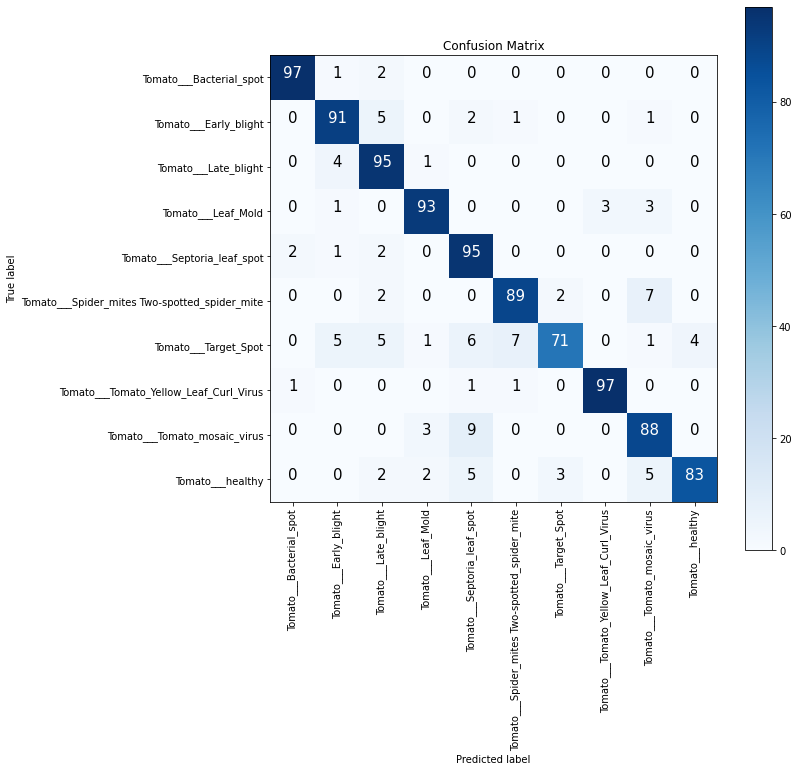

In [181]:
make_confusion_matrix(y_true, y_pred, class_names)

In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.97      0.97       100
                        Tomato___Early_blight       0.88      0.91      0.90       100
                         Tomato___Late_blight       0.84      0.95      0.89       100
                           Tomato___Leaf_Mold       0.93      0.93      0.93       100
                  Tomato___Septoria_leaf_spot       0.81      0.95      0.87       100
Tomato___Spider_mites Two-spotted_spider_mite       0.91      0.89      0.90       100
                         Tomato___Target_Spot       0.93      0.71      0.81       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.97      0.97       100
                 Tomato___Tomato_mosaic_virus       0.84      0.88      0.86       100
                             Tomato___healthy       0.95      0.83      0.89       100

                                     accu

# #Done!

# #Implimentation of Xception Model !

In [102]:
import tensorflow as tf

# Load the pre-trained Xception model without the top classification layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
xception.trainable = False

# Create your own classification layers
# Create your own classification layers
model6 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


83697664/83683744 [==============================] - 1s 0us/step


In [103]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 21,388,594
Trainable params: 527,114
Non-trainable params: 20,861,480
_________________________________________________________________


In [105]:
# Compile the model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
from tensorflow.keras.callbacks import EarlyStopping

In [110]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [111]:
# Model fitting
history = model6.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/50
313/313 [==============================] - 44s 141ms/step - loss: 0.9357 - accuracy: 0.6601 - val_loss: 0.9710 - val_accuracy: 0.6800
Epoch 2/50
313/313 [==============================] - 44s 140ms/step - loss: 0.9267 - accuracy: 0.6617 - val_loss: 0.9480 - val_accuracy: 0.7020
Epoch 3/50
313/313 [==============================] - 44s 140ms/step - loss: 0.9276 - accuracy: 0.6582 - val_loss: 0.8946 - val_accuracy: 0.7160
Epoch 4/50
313/313 [==============================] - 43s 138ms/step - loss: 0.9225 - accuracy: 0.6626 - val_loss: 0.9078 - val_accuracy: 0.7160
Epoch 5/50
313/313 [==============================] - 44s 139ms/step - loss: 0.9428 - accuracy: 0.6521 - val_loss: 0.9409 - val_accuracy: 0.6990
Epoch 6/50
313/313 [==============================] - 43s 139ms/step - loss: 0.8978 - accuracy: 0.6730 - val_loss: 0.9021 - val_accuracy: 0.7080
Epoch 7/50
313/313 [==============================] - 43s 139ms/step - loss: 0.9054 - accuracy: 0.6671 - val_loss: 0.8988 - val_ac

In [112]:
model6.evaluate(train_data)

313/313 [==============================] - 40s 128ms/step - loss: 0.5697 - accuracy: 0.8022


[0.5697292685508728, 0.8022000193595886]

In [113]:
model6.evaluate(test_data)

32/32 [==============================] - 4s 128ms/step - loss: 0.9042 - accuracy: 0.7100


[0.9042072296142578, 0.7099999785423279]

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [115]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model6.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

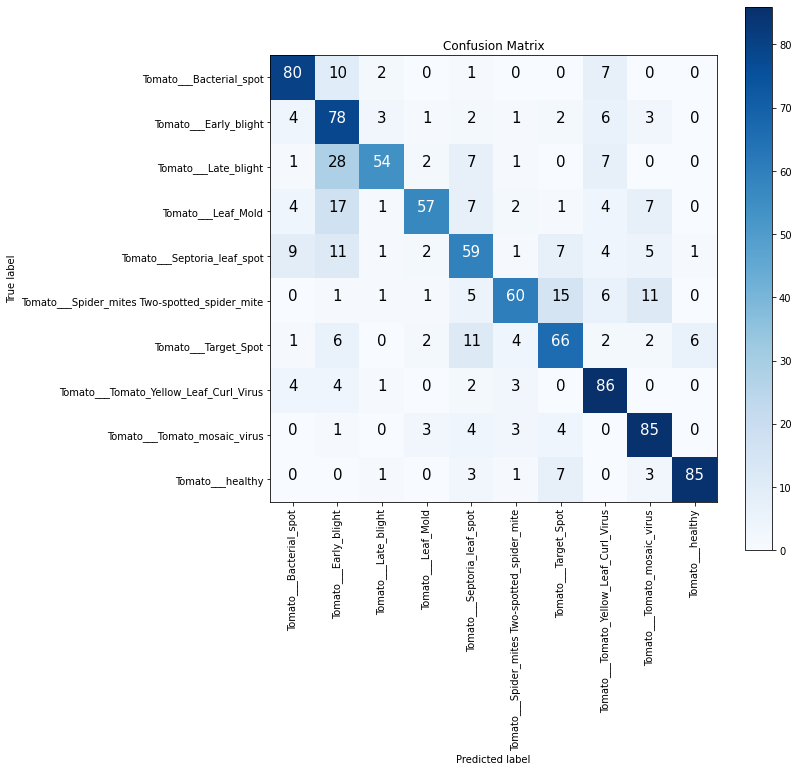

In [116]:
make_confusion_matrix(y_true, y_pred, class_names)

In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.78      0.80      0.79       100
                        Tomato___Early_blight       0.50      0.78      0.61       100
                         Tomato___Late_blight       0.84      0.54      0.66       100
                           Tomato___Leaf_Mold       0.84      0.57      0.68       100
                  Tomato___Septoria_leaf_spot       0.58      0.59      0.59       100
Tomato___Spider_mites Two-spotted_spider_mite       0.79      0.60      0.68       100
                         Tomato___Target_Spot       0.65      0.66      0.65       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.70      0.86      0.77       100
                 Tomato___Tomato_mosaic_virus       0.73      0.85      0.79       100
                             Tomato___healthy       0.92      0.85      0.89       100

                                     accu

# #Done!

# #Implimentation of InceptionResNetV2 Model !

In [119]:
import tensorflow as tf

# Load the pre-trained InceptionResNetV2 model without the top classification layers
inception_resnet = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
inception_resnet.trainable = False

# Create your own classification layers
model7 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    inception_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


219070464/219055592 [==============================] - 1s 0us/step


In [120]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 54,732,778
Trainable params: 396,042
Non-trainable params: 54,336,736
_________________________________________________________________


In [121]:
# Compile the model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
from tensorflow.keras.callbacks import EarlyStopping

In [126]:
checkpoint_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [127]:
# Model fitting
history = model7.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/50
313/313 [==============================] - 77s 212ms/step - loss: 8.3601 - accuracy: 0.0967 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/50
313/313 [==============================] - 62s 198ms/step - loss: 2.3031 - accuracy: 0.0971 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 3/50
313/313 [==============================] - 62s 198ms/step - loss: 2.3757 - accuracy: 0.0951 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 4/50
313/313 [==============================] - 62s 197ms/step - loss: 2.3028 - accuracy: 0.0972 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 5/50
313/313 [==============================] - 62s 198ms/step - loss: 2.3030 - accuracy: 0.0943 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 6/50
313/313 [==============================] - 62s 197ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 7/50
313/313 [==============================] - 62s 197ms/step - loss: 2.3028 - accuracy: 0.0938 - val_loss: 2.3034 - val_ac

In [128]:
model7.evaluate(train_data)

313/313 [==============================] - 56s 178ms/step - loss: 2.3026 - accuracy: 0.1000


[2.302588939666748, 0.10000000149011612]

In [129]:
model7.evaluate(test_data)

32/32 [==============================] - 6s 177ms/step - loss: 2.3034 - accuracy: 0.1000


[2.303375244140625, 0.10000000149011612]

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import itertools

In [131]:
import numpy as np
y_true = np.array([])
y_pred = np.array([])

for x, y in test_data:
    y_true_batch = np.argmax(y, axis=-1)
    y_pred_batch = np.argmax(model7.predict(x), axis=-1)
    
    y_true = np.concatenate([y_true, y_true_batch], axis=0)
    y_pred = np.concatenate([y_pred, y_pred_batch], axis=0)

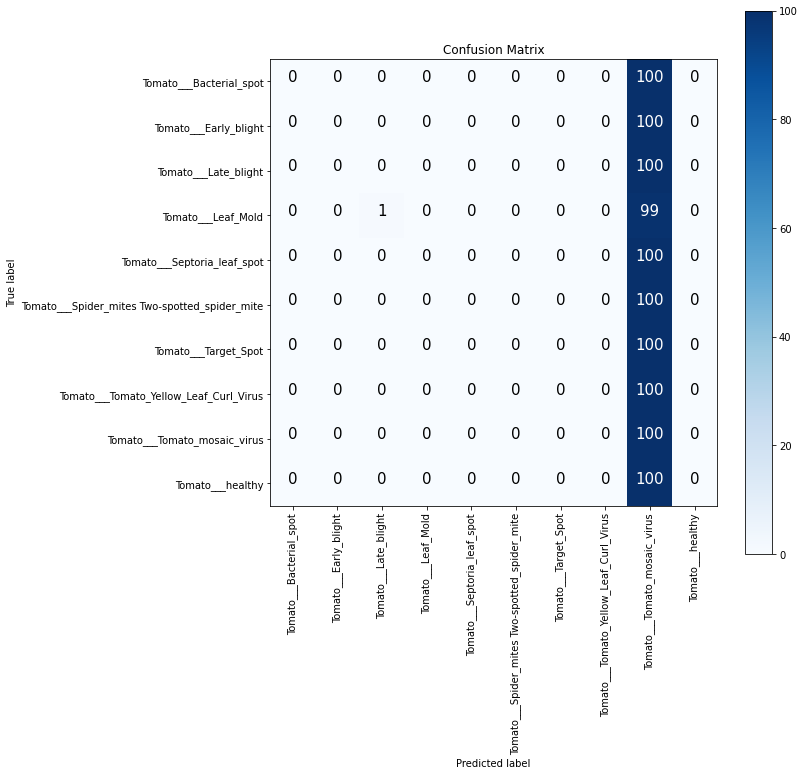

In [132]:
make_confusion_matrix(y_true, y_pred, class_names)

In [133]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))    

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.00      0.00      0.00       100
                        Tomato___Early_blight       0.00      0.00      0.00       100
                         Tomato___Late_blight       0.00      0.00      0.00       100
                           Tomato___Leaf_Mold       0.00      0.00      0.00       100
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00       100
Tomato___Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00       100
                         Tomato___Target_Spot       0.00      0.00      0.00       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00       100
                 Tomato___Tomato_mosaic_virus       0.10      1.00      0.18       100
                             Tomato___healthy       0.00      0.00      0.00       100

                                     accu

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# #Combining the two model VGG-16 AND VGG-19 Model !

In [1]:
import tensorflow as tf

# Load the pre-trained VGG16 model without the top classification layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load the pre-trained VGG19 model without the top classification layers
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
vgg16.trainable = False
vgg19.trainable = False

# Create your own classification layers for VGG16
model_vgg16 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Create your own classification layers for VGG19
model_vgg19 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Combine the predictions of both models
ensemble_input = tf.keras.Input(shape=(224, 224, 3))
vgg16_pred = model_vgg16(ensemble_input)
vgg19_pred = model_vgg19(ensemble_input)
ensemble_output = tf.keras.layers.Average()([vgg16_pred, vgg19_pred])

# Create the final ensemble model
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)


80150528/80134624 [==============================] - 1s 0us/step


NameError: name 'num_classes' is not defined